C:\Users\COOL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\COOL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 1.0444, Train Acc: 59.12%, Val Loss: 0.4457, Val Acc: 86.24%
Epoch [2/50], Train Loss: 0.5020, Train Acc: 81.12%, Val Loss: 0.2735, Val Acc: 90.74%
Epoch [3/50], Train Loss: 0.3271, Train Acc: 89.37%, Val Loss: 0.1557, Val Acc: 95.50%
Epoch [4/50], Train Loss: 0.2488, Train Acc: 92.12%, Val Loss: 0.1896, Val Acc: 94.18%
Epoch [5/50], Train Loss: 0.2317, Train Acc: 92.44%, Val Loss: 0.0932, Val Acc: 97.35%
Epoch [6/50], Train Loss: 0.1967, Train Acc: 92.86%, Val Loss: 0.0668, Val Acc: 97.62%
Epoch [7/50], Train Loss: 0.1782, Train Acc: 94.24%, Val Loss: 0.0496, Val Acc: 98.68%
Epoch [8/50], Train Loss: 0.1786, Train Acc: 93.76%, Val Loss: 0.0858, Val Acc: 96.56%
Epoch [9/50], Train Loss: 0.1307, Train Acc: 95.08%, Val Loss: 0.0415, Val Acc: 98.68%
Epoch [10/50], Train Loss: 0.1141, Train Acc: 95.88%, Val Loss: 0.0358, Val Acc: 98.68%
Epoch [11/50], Train Loss: 0.0967, Train Acc: 96.72%, Val Loss: 0.0309, Val Acc: 99.47%
Epoch [12/50], Train Loss: 0.1067, Train 

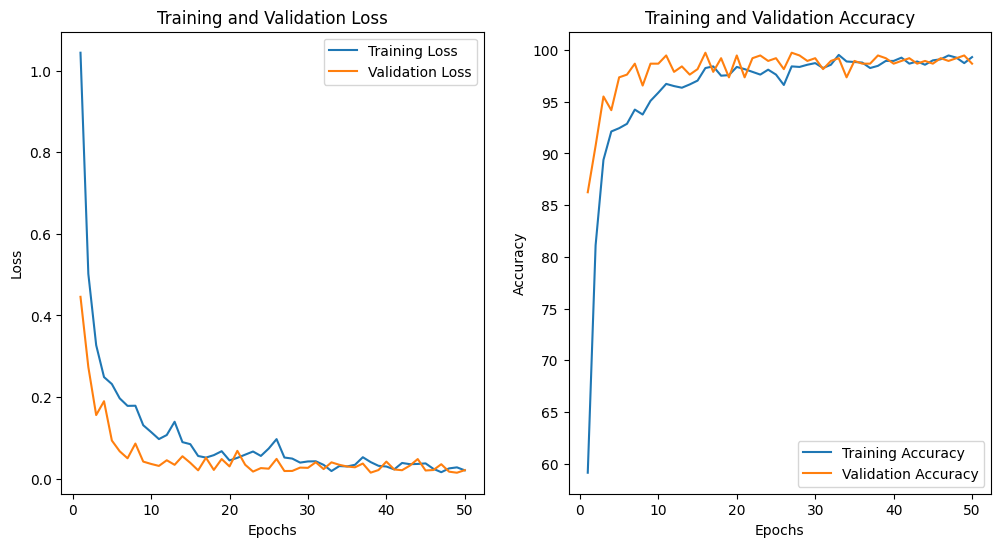

Accuracy: 98.68%


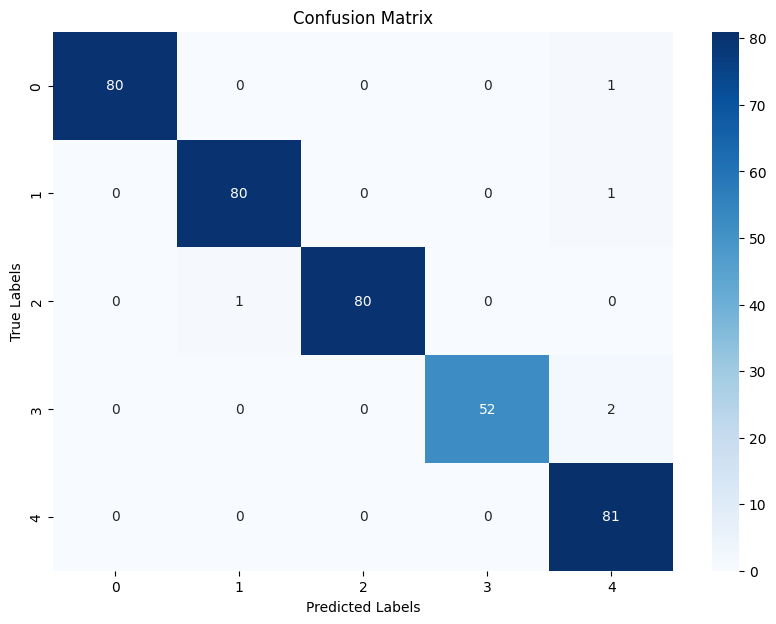

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # AlexNet requires input size of 224x224
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Load datasets
train_dataset = datasets.ImageFolder(root='Training_set', transform=transform)
test_dataset = datasets.ImageFolder(root='Test_Set', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)

# # Freeze the parameters so that gradients are not computed for them
# for param in alexnet.parameters():
#     param.requires_grad = False

# Modify the last fully connected layer to match your number of classes
num_classes = 5
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, num_classes)

# Move the model to GPU if available
alexnet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.classifier.parameters(), lr=0.0001)

# To track the losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    alexnet.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = alexnet(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss = running_val_loss / len(test_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Plotting the training and validation accuracy and loss curves
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set (already done in your original code)
alexnet.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store true and predicted labels for confusion matrix
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()

# Plot confusion matrix using stored true and predicted labels
classes = train_dataset.classes  # Extract class names from the dataset
plot_confusion_matrix(y_true, y_pred, classes)
